In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize  
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import random

# Import data

In [2]:
dataset = pd.read_json('/home/yves/Desktop/Data_Science/ADM1/adm_hw2/data/matches/matches_England.json')

# RQ1 Who wants to be a Champion? 

In [3]:
# Take only the columns usefull for this task
sub_dataset = dataset[['status','winner', 'label']] 

In [4]:
# Now I will extract all the information contained in the label column and rearrange it!
label = pd.DataFrame(sub_dataset['label'])

In [5]:
label.head(3)

,label
0,"Burnley - AFC Bournemouth, 1 - 2"
1,"Crystal Palace - West Bromwich Albion, 2 - 0"
2,"Huddersfield Town - Arsenal, 0 - 1"


In [6]:
new_dataset = label["label"].str.split(",",n = 1, expand = True) # split the column label

In [7]:
new_dataset.columns = ("teams", "score") # rename the columns

In [8]:
new_dataset.head(3)

,teams,score
0,Burnley - AFC Bournemouth,1 - 2
1,Crystal Palace - West Bromwich Albion,2 - 0
2,Huddersfield Town - Arsenal,0 - 1


In [9]:
teams = new_dataset["teams"].str.split("-",n = 1, expand = True) # split the teams column

In [10]:
score = new_dataset["score"].str.split("-",n = 1, expand = True) # split the score column

In [37]:
# merge teams and score to the sub_dataset
final1 = pd.merge(teams, score, left_index=True, right_index=True)
dataset = pd.merge(sub_dataset, final1, left_index=True, right_index=True)

In [38]:
dataset.head(5)

,status,winner,label,0_x,1_x,0_y,1_y
0,Played,1659,"Burnley - AFC Bournemouth, 1 - 2",Burnley,AFC Bournemouth,1,2
1,Played,1628,"Crystal Palace - West Bromwich Albion, 2 - 0",Crystal Palace,West Bromwich Albion,2,0
2,Played,1609,"Huddersfield Town - Arsenal, 0 - 1",Huddersfield Town,Arsenal,0,1
3,Played,1612,"Liverpool - Brighton & Hove Albion, 4 - 0",Liverpool,Brighton & Hove Albion,4,0
4,Played,1611,"Manchester United - Watford, 1 - 0",Manchester United,Watford,1,0


In [39]:
dataset.drop(columns = ['label'], inplace=True)

In [40]:
# rename columns
dataset.columns = ("status", "winner", "home", "away", "home_score", "away_score")

In [41]:
dataset.head(2)

,status,winner,home,away,home_score,away_score
0,Played,1659,Burnley,AFC Bournemouth,1,2
1,Played,1628,Crystal Palace,West Bromwich Albion,2,0


In [42]:
# adjust the name spacing
home = []
for i in dataset['home']:
    j = " ".join(i.split())
    home.append(j)
away = []
for i in dataset['away']:
    j = " ".join(i.split())
    away.append(j)

In [43]:
dataset['home'] = home
dataset['away'] = away

In [44]:
# points assignation
# 3 points to the winning team
# 1 point when there's a draw
# 0 point to the losing team

home_points = []
away_points = []
for i in range(len(dataset["home_score"])):
    if int(dataset["home_score"][i]) == int(dataset["away_score"][i]):
        home_points.append(1)
        away_points.append(1)
    elif int(dataset["home_score"][i]) > int(dataset["away_score"][i]):
        home_points.append(3)
        away_points.append(0)
    else:
        home_points.append(0)
        away_points.append(3)

In [45]:
dataset['home_points'] = home_points

In [46]:
dataset['away_points'] = away_points

In [47]:
# zip the team names and their points in orther to create a new dataset 
from itertools import chain
teams_name = list(chain.from_iterable(zip(dataset["home"], dataset["away"])))
points = list(chain.from_iterable(zip(dataset["home_points"], dataset["away_points"])))

In [48]:
# final dataset
final_dataset = {'teams_name':teams_name,'points':points}
final_dataset = pd.DataFrame(final_dataset)
final_dataset.head(3)

,teams_name,points
0,Burnley,0
1,AFC Bournemouth,3
2,Crystal Palace,3


In [49]:
final_dataset = final_dataset.groupby('teams_name')['points'].apply(lambda x: pd.Series(list(x))).unstack()

In [50]:
# change the column names
q = final_dataset.columns      
a = 'week'
b = []
for i in range(1, len(q) +1):
    b.append(a + str(i))
final_dataset.columns = b

In [51]:
final_transp = final_dataset.T

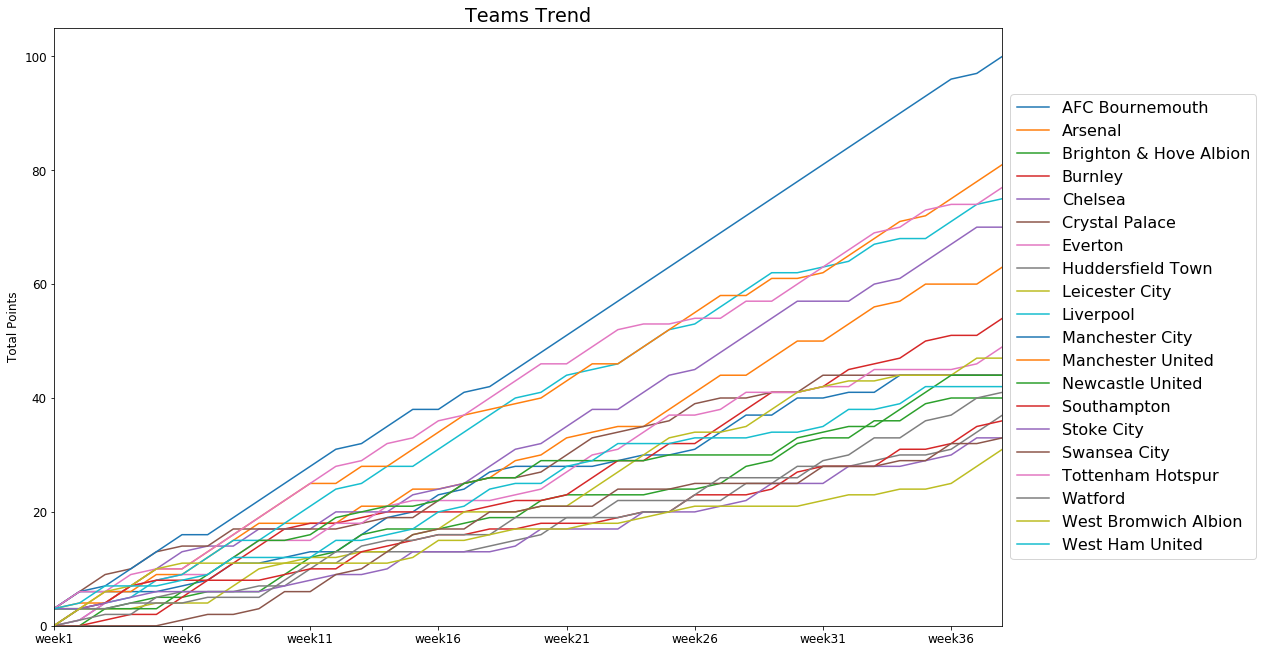

In [52]:
final_transp.cumsum().plot(figsize=(17,11))
plt.rcParams.update({'font.size': 16})

plt.ylim(0, 105)
plt.xlim(0, 37)
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.50))
plt.ylabel('Total Points')
plt.title('Teams Trend')
plt.show()

In [53]:
# function to count the number of consecutive wins or loses
def consecutive_act(arr, n):
    arr = np.array(list(arr))    # convert elements to `str`
    n_pos = np.argwhere(arr == str(n)).ravel()  # find out positions of n
    if not n_pos.size:  # if there are no three, return 0
        return 0

    full = np.arange(n_pos[0], n_pos[-1]+1)  # get the range of spread of n
    # get the indices where n` or  was flipped to something else
    diff = np.setdiff1d(full, n_pos)
    if not diff.size:     # if there are no bit flips, return the size of the full range
        return len(full)  

    # break the array into pieces wherever there's a bit flip and the result is the size of the largest chunk
    
    pos, difs = full[0], []
    for el in diff:
        difs.append(el - pos)
        pos = el + 1

    difs.append(full[-1]+1 - pos)

    # return size of the largest chunk
    res = max(difs) if max(difs) != 1 else 0

    return res
        

In [54]:
# assuming you have your data in `df`
final_dataset['concated'] = final_dataset.astype(str).apply(lambda x: ''.join(x), axis=1)
final_dataset['consecutive_win'] = final_dataset.concated.apply(lambda x: consecutive_act(x, 3))
final_dataset['consecutive_lose'] = final_dataset.concated.apply(lambda x: consecutive_act(x, 0))
final_dataset.drop(columns = ['concated'], inplace=True)

In [55]:
final_dataset.head(2)

,week1,week2,week3,week4,week5,week6,week7,week8,week9,week10,...,week31,week32,week33,week34,week35,week36,week37,week38,consecutive_win,consecutive_lose
teams_name,,,,,,,,,,,,,,,,,,,,,
AFC Bournemouth,3,3,0,0,0,1,1,3,0,1,...,0,1,0,3,0,0,0,0,2,4
Arsenal,3,0,3,0,3,0,3,3,3,0,...,0,3,3,1,3,0,0,3,3,3


In [56]:
# top 2 highest consecutive wins
order_by_wins = final_dataset.sort_values('consecutive_win', ascending=False).index[:2]

In [57]:
# top 2 highest consecutive loses
order_by_lose = final_dataset.sort_values('consecutive_lose', ascending=False).index[:2]

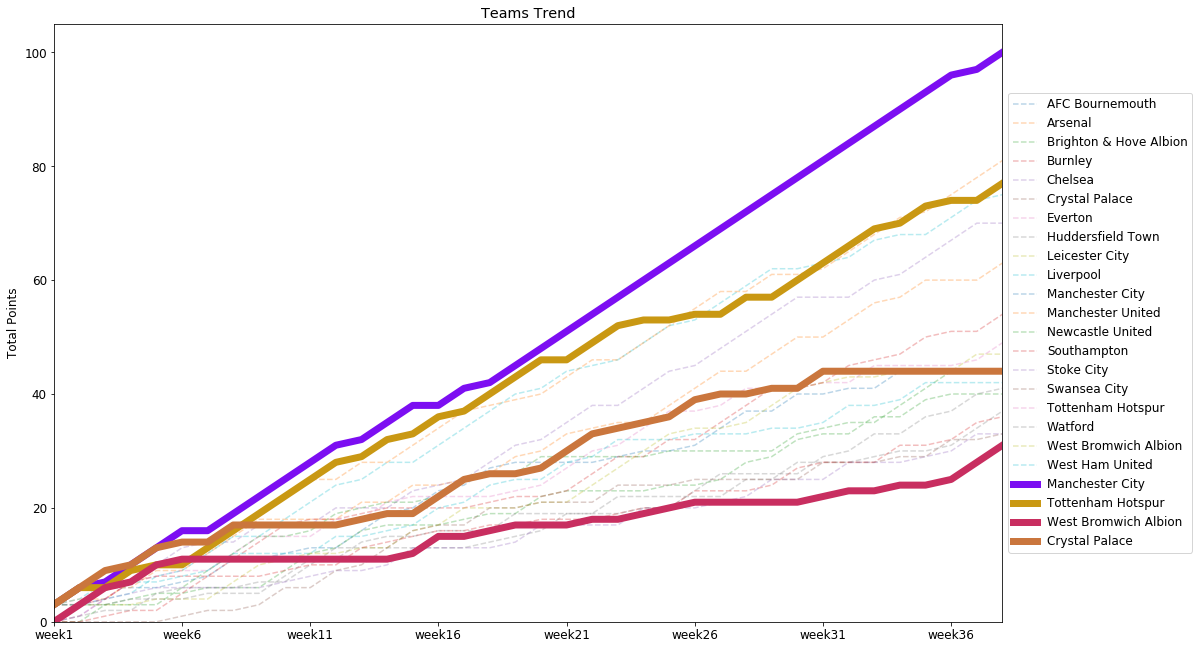

In [58]:
fig = plt.figure(figsize=(17,11))
plt.rcParams.update({'font.size': 12})

col = []
for i in range(4):
    r = lambda: random.randint(0,255)
    colr = '#{:02x}{:02x}{:02x}'.format(r(), r(), r())
    col.append(colr)

# multiple line plot
for column in final_transp:
    final_transp[column].cumsum().plot(x='index', alpha = 0.3, linestyle='--')
    
for j in range(2):
    plt.plot(final_transp[order_by_wins[j]].cumsum(), color = col[:len(order_by_wins)][j], 
             linewidth=7, alpha=1, label= order_by_wins[j])
    
for i in range(2):
    plt.plot(final_transp[order_by_lose[i]].cumsum(), color = col[-len(order_by_lose):][i], 
             linewidth=7, alpha=1, label= order_by_lose[i])

    
    

plt.ylim(0, 105)
plt.xlim(0, 37)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.50))
plt.ylabel('Total Points')
plt.title('Teams Trend')
plt.show()

In [60]:
print('The teams with the longest winning streak are: ' + order_by_wins[0] + ' and ' + order_by_wins[1])
print('The teams with the longest losing streak are: ' + order_by_lose[0] + ' and ' + order_by_lose[1])

The teams with the longest winning streak are: Manchester City and Tottenham Hotspur
The teams with the longest losing streak are: West Bromwich Albion and Crystal Palace
